In [1]:
import os
import json
import numpy as np

# Strategy:
# Extract pos_ner + embeddings & rolling embeddings
# Flag bad ner, use POS to get the numbers and potential other bad stuff
# Project embeddings & rolling embeddings, cosine sim with all other clusters ?
# Then rules for numbers

text_path = '../example_conversations/english/labelled_text_conv_1.json'

with open(text_path, 'r') as f:
    labelled_data = json.load(f)


In [2]:
unlabelled_data = [list(i.keys())[0] for i in labelled_data]

In [3]:
from pos_ner import get_pos, get_ner, get_pos_2

pos = get_pos_2(unlabelled_data)
ner, entities = get_ner(unlabelled_data)

/Users/nizarmichaud/PycharmProjects/DeID/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2025-06-15 16:09:24,179 SequenceTagger predicts: Dictionary with 17 tags: NOUN, PUNCT, ADP, VERB, ADJ, DET, PROPN, ADV, PRON, AUX, CCONJ, NUM, SCONJ, PART, X, SYM, INTJ


Device set to use mps:0
/Users/nizarmichaud/PycharmProjects/DeID/venv/lib/python3.9/site-packages/transformers/pipelines/token_classification.py:170: UserWarning: `grouped_entities` is deprecated and will be removed in version v5.0.0, defaulted to `aggregation_strategy="simple"` instead.
  warnings.warn(


In [4]:
fit_data = [[i, 0] for i in unlabelled_data]

for i, c in enumerate(ner):
    word, label = c
    assert fit_data[i][0] == word, f'Unmatched words in NER and data: position {i} ; word: {word} ; data: {fit_data[i]}'

    if label != '0':
        fit_data[i][1] = 1


In [6]:
len(pos), len(fit_data)

(385, 385)

In [7]:
fit_data

[['Hi', 0],
 ['can', 0],
 ['you', 0],
 ['believe', 0],
 ['the', 0],
 ['bus', 0],
 ['was', 0],
 ['late', 0],
 ['again', 0],
 ['this', 0],
 ['morning', 0],
 ['Yeah', 0],
 ['it’s', 0],
 ['always', 0],
 ['Line', 0],
 ['25', 0],
 ['I', 0],
 ['was', 0],
 ['supposed', 0],
 ['to', 0],
 ['be', 0],
 ['at', 0],
 ['4', 1],
 ['Place', 1],
 ['du', 1],
 ['Marché', 1],
 ['by', 0],
 ['8h30', 0],
 ['Did', 0],
 ['you', 0],
 ['see', 0],
 ['that', 0],
 ['new', 0],
 ['café', 0],
 ['on', 0],
 ['Rue', 1],
 ['de', 1],
 ['la', 1],
 ['Paix', 1],
 ['No', 0],
 ['but', 0],
 ['Clara', 1],
 ['mentioned', 0],
 ['it', 0],
 ['to', 0],
 ['me', 0],
 ['Speaking', 0],
 ['of', 0],
 ['Clara’s', 0],
 ['birthday', 0],
 ['is', 0],
 ['on', 0],
 ['March', 0],
 ['18th', 0],
 ['right', 0],
 ['Yes', 0],
 ['but', 0],
 ['she’s', 0],
 ['having', 0],
 ['the', 0],
 ['party', 0],
 ['next', 0],
 ['Friday', 0],
 ['at', 0],
 ['her', 0],
 ['place', 0],
 ['in', 0],
 ['Lausanne', 1],
 ['I’ll', 0],
 ['need', 0],
 ['to', 0],
 ['check', 0],
 ['with

In [53]:
# Get embeddings for all PROPN and check whether they're close to any sensitive cluster

from embeddings import get_embeddings, get_roll_embeddings

propn_idx = []
for i, (w, l) in enumerate(pos):
    #if l == 'PROPN' and fit_data[i][1] == 0:
    if l == 'PROPN':
        propn_idx.append(i)

propn = [pos[i][0] for i in propn_idx]

windowed_propn = []
win_down, win_up = -2, 2
for idx in propn_idx:
    start, end = idx + win_down, idx + win_up
    start = max(0, start)
    end = min(end, len(pos))

    windowed_propn.append(' '.join(unlabelled_data[start:end]))

propn, windowed_propn

(['Yeah',
  'Line',
  'du',
  'Marché',
  'Rue',
  'Paix',
  'No',
  'Clara',
  'Clara’s',
  'March',
  'Friday',
  'Lausanne',
  'Emma',
  'Dr',
  'Feller',
  'Haha',
  'Hôpital',
  'Tour',
  'Avenue',
  'J-D',
  'Maillard',
  'Meyrin',
  'Versoix',
  'Zürich',
  'Winterthur',
  'Swiss',
  'Switching',
  'July',
  'Parc',
  'des',
  'Bastions',
  'David',
  'David',
  'Steiner',
  'UNIL',
  'David',
  'UBS',
  'Rue',
  'du',
  'Rhône',
  'Ah',
  'okay',
  'Davids',
  'Yeah',
  'Sophie',
  'Klein',
  'Helsana',
  'Jean-Marc',
  'Yes',
  'Italy',
  'Florence',
  'May',
  'Nice',
  'Ticino',
  'Lugano',
  'Sounds',
  'June',
  'Congrats',
  'Nora',
  'Alright',
  'Dr',
  'Maillard',
  'Place',
  'Gare',
  'Thanks'],
 ['this morning Yeah it’s',
  'it’s always Line 25',
  '4 Place du Marché',
  'Place du Marché by',
  'café on Rue de',
  'de la Paix No',
  'la Paix No but',
  'No but Clara mentioned',
  'Speaking of Clara’s birthday',
  'is on March 18th',
  'party next Friday at',
  'plac

In [54]:
embeddings = get_embeddings(propn)
windowed_embeddings = get_embeddings(windowed_propn)

In [74]:
from sklearn.metrics.pairwise import cosine_similarity

sensitive_types = ['location', 'name', 'time', 'other']
context_types = ['words', 'context_ex']

for context_type in context_types:

    if context_type == 'words':
        base_embeddings = embeddings
    else:
        base_embeddings = windowed_embeddings

    for sensitive_type in sensitive_types:
        sensitive_cluster = np.load(os.path.join('../example_identifiers_embeddings', f'english_{sensitive_type}_{context_type}.npy'))

        # cosine sim --> (n_samples, n_features)

        all_distances = cosine_similarity(base_embeddings, sensitive_cluster)

        mean_distances = all_distances.max(axis=1)

        print(all_distances)
        break
    break

[[0.8630061  0.7867049  0.7746125  ... 0.7062141  0.43990022 0.495287  ]
 [0.85529953 0.78247476 0.761657   ... 0.6845958  0.4251393  0.4802265 ]
 [0.847109   0.76296246 0.7624173  ... 0.70856816 0.44244182 0.5135015 ]
 ...
 [0.8724633  0.80072206 0.78156555 ... 0.7107959  0.43733606 0.48995066]
 [0.9422861  0.98002434 0.9909603  ... 0.90613586 0.48337996 0.38727528]
 [0.83713967 0.7572371  0.7346846  ... 0.65947944 0.40983614 0.4731254 ]]


In [75]:
for i, n in enumerate(all_distances.mean(axis=1)):
    print(i, n, propn[i])

0 0.7605391 Yeah
1 0.7519182 Line
2 0.7481051 du
3 0.8973084 Marché
4 0.9102031 Rue
5 0.9112472 Paix
6 0.7850048 No
7 0.9059008 Clara
8 0.9121472 Clara’s
9 0.78753996 March
10 0.7798803 Friday
11 0.9082153 Lausanne
12 0.81355363 Emma
13 0.748528 Dr
14 0.9043144 Feller
15 0.7896939 Haha
16 0.9101427 Hôpital
17 0.7330829 Tour
18 0.91794646 Avenue
19 0.90764254 J-D
20 0.9041505 Maillard
21 0.90310144 Meyrin
22 0.91266954 Versoix
23 0.9061508 Zürich
24 0.9053051 Winterthur
25 0.9082142 Swiss
26 0.9077374 Switching
27 0.8400852 July
28 0.9166578 Parc
29 0.7517117 des
30 0.91036654 Bastions
31 0.74966615 David
32 0.74966615 David
33 0.9104786 Steiner
34 0.9016563 UNIL
35 0.74966615 David
36 0.90785795 UBS
37 0.9102031 Rue
38 0.7481051 du
39 0.9129769 Rhône
40 0.76903063 Ah
41 0.08452636 okay
42 0.9147377 Davids
43 0.7605391 Yeah
44 0.8992183 Sophie
45 0.90097296 Klein
46 0.9116868 Helsana
47 0.8880813 Jean-Marc
48 0.8176114 Yes
49 0.9106272 Italy
50 0.9117521 Florence
51 0.7364196 May
52 0.7

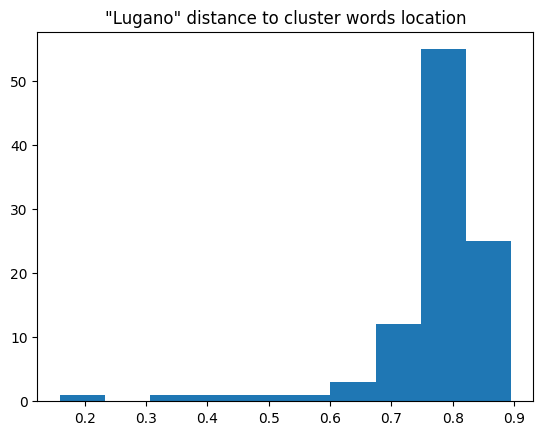

In [76]:
import matplotlib.pyplot as plt

idx = 54
plt.hist(all_distances[0])
plt.title(f'"{propn[idx]}" distance to cluster words location')
plt.show()